# Light Feature Engineering/ LGBM by Meter Type Predictions



In [14]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import gc

## Reduce Memory Usage Function

In [15]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Data loading

In [16]:
%%time
PATH = 'ashrae-energy-prediction/'

train_df = pd.read_csv(PATH + 'train.csv')

building_meta_df = pd.read_csv(PATH + 'building_metadata.csv')

CPU times: user 6.72 s, sys: 1.48 s, total: 8.2 s
Wall time: 7.5 s


# Feature Engineering

1. Timestamp align of weather data and interpolation of nan data.
2. Convert timestamp field to pandas datetime object to create time based features
3. Remove the first section of 0 data for the site 1 buildings in the training set. 
4. Creation of time features: hour, day of the week, weekend indicator based on a corresponding list of major US holidays.
5. Log + 1 transform on meter readings(target) to reduce effect of outliers during training.
6. Creation of aggregation features for each building: median, min, max, std, mean.
7. Fill nans in weather data by interpolation.
8. Creation of lag features on weather data in 3 hour and 72 hour windows.
9. Label encoding of primary use type of each building
10. Reduce memory usage
11. Merge building metadata and weather data to training set to create one large dataset

## Weather Timestamp alignment

In [17]:
weather_train_df = pd.read_csv(PATH + 'weather_train.csv',  parse_dates=['timestamp'])
weather_test_df = pd.read_csv(PATH + 'weather_test.csv',  parse_dates=['timestamp'])
weather = pd.concat([weather_train_df,weather_test_df],ignore_index=True)
del weather_train_df, weather_test_df
weather_key = ['site_id', 'timestamp']
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()
del weather
gc.collect();

In [18]:
temp_skeleton.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417016 entries, 0 to 417015
Data columns (total 3 columns):
site_id            417016 non-null int64
timestamp          417016 non-null datetime64[ns]
air_temperature    416857 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 12.7 MB


In [19]:
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 15, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 15)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    df['timestamp'] = df['timestamp'].astype('str')
    del df['timestamp_aligned']
    del df['offset']
    return df

In [20]:
weather_train_df = pd.read_csv(PATH + 'weather_train.csv', parse_dates = ["timestamp"])

In [21]:
weather_train_df = timestamp_align(weather_train_df)
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

## Prepare Timestamps

In [22]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

In [23]:
def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    fig = px.line(train_temp_df_meter, x='date', y='meter_reading_log1p')
    fig.show()

In [24]:
plot_date_usage(train_df, meter=3, building_id=1000)

In [25]:
train_df = train_df.drop(columns=['date'])

## Removing data on site_id 0

In [26]:
building_meta_df[building_meta_df.site_id == 0]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
100,0,100,Lodging/residential,24456,1968.0,NaN
101,0,101,Office,18860,1986.0,NaN
102,0,102,Office,15876,1983.0,NaN
103,0,103,Education,21657,2016.0,NaN


In [27]:
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [28]:
debug = False

## Creation of  time features

In [29]:
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    

In [30]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
    df["week"] = df["timestamp"].dt.week
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["is_holiday"] = (df.timestamp.dt.date.astype("str").isin(holidays)).astype(int)


In [31]:
preprocess(train_df)

In [32]:
train_df

,building_id,meter,timestamp,meter_reading,meter_reading_log1p,hour,week,dayofweek,is_holiday
103,105,0,2016-01-01 00:00:00,23.3036,3.190624,0,53,4,1
104,106,0,2016-01-01 00:00:00,0.3746,0.318163,0,53,4,1
105,106,3,2016-01-01 00:00:00,0.0000,0.000000,0,53,4,1
106,107,0,2016-01-01 00:00:00,175.1840,5.171529,0,53,4,1
107,108,0,2016-01-01 00:00:00,91.2653,4.524668,0,53,4,1
...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.7500,2.277267,23,52,5,0
20216096,1445,0,2016-12-31 23:00:00,4.8250,1.762159,23,52,5,0
20216097,1446,0,2016-12-31 23:00:00,0.0000,0.000000,23,52,5,0
20216098,1447,0,2016-12-31 23:00:00,159.5750,5.078761,23,52,5,0


In [33]:
df_group = train_df.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

train_df['building_mean'] = train_df['building_id'].map(building_mean)
train_df['building_median'] = train_df['building_id'].map(building_median)
train_df['building_min'] = train_df['building_id'].map(building_min)
train_df['building_max'] = train_df['building_id'].map(building_max)
train_df['building_std'] = train_df['building_id'].map(building_std)


In [34]:
train_df

,building_id,meter,timestamp,meter_reading,meter_reading_log1p,hour,week,dayofweek,is_holiday,building_mean,building_median,building_min,building_max,building_std
103,105,0,2016-01-01 00:00:00,23.3036,3.190624,0,53,4,1,4.316406,4.332031,3.191406,5.164062,0.318115
104,106,0,2016-01-01 00:00:00,0.3746,0.318163,0,53,4,1,0.887695,0.559082,0.000000,3.712891,0.967773
105,106,3,2016-01-01 00:00:00,0.0000,0.000000,0,53,4,1,0.887695,0.559082,0.000000,3.712891,0.967773
106,107,0,2016-01-01 00:00:00,175.1840,5.171529,0,53,4,1,4.570312,5.781250,0.039703,6.382812,2.009766
107,108,0,2016-01-01 00:00:00,91.2653,4.524668,0,53,4,1,5.457031,5.449219,4.417969,6.113281,0.216187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.7500,2.277267,23,52,5,0,2.027344,2.037109,0.000000,3.605469,0.467041
20216096,1445,0,2016-12-31 23:00:00,4.8250,1.762159,23,52,5,0,1.719727,1.761719,1.223633,2.472656,0.232422
20216097,1446,0,2016-12-31 23:00:00,0.0000,0.000000,23,52,5,0,0.960938,0.000000,0.000000,2.791016,1.073242
20216098,1447,0,2016-12-31 23:00:00,159.5750,5.078761,23,52,5,0,5.230469,5.234375,4.894531,5.562500,0.128540


## Fill Nan value in weather dataframe by interpolation

In [35]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2015-12-31 20:00:00,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0
1,0,2015-12-31 21:00:00,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5
2,0,2015-12-31 22:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2015-12-31 23:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 00:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [36]:
 weather_train_df.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139773.000000,122545.000000,139773.000000,113500.000000,131018.000000,139773.000000,139773.000000
mean,7.478977,14.418098,2.635293,7.347901,2.581841,1016.137913,179.430384,3.559284
std,4.604744,10.626006,2.757484,9.788823,11.583021,7.633467,110.826969,2.334483
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.700000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [37]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,8763,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,8755,8755,0,0
6,0,0,0,0,0,0,0,0,0
7,0,0,0,8614,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


## Creation of lag features on weather data in 3 hour and 72 hour windows


In [38]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [39]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [40]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 20:00:00,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,25.000000,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 21:00:00,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5,24.703125,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 22:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,24.062500,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 23:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,22.765625,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2016-01-01 00:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,21.296875,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477


In [41]:
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])

In [42]:
# categorize primary_use column to reduce memory on merge...

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


30890

In [43]:
reduce_mem_usage(train_df, use_float16=True)
reduce_mem_usage(building_meta_df, use_float16=True)
reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1705.45 MB
Memory usage after optimization is: 739.03 MB
Decreased by 56.7%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 74.9%
Memory usage of dataframe is 24.53 MB
Memory usage after optimization is: 18.00 MB
Decreased by 26.6%


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 20:00:00,25.000000,6.0,20.000000,-1.0,1019.5,0.0,0.000000,25.000000,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 21:00:00,24.406250,4.0,21.093750,-1.0,1020.0,70.0,1.500000,24.703125,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 22:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000,24.062500,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 23:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000,22.765625,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2016-01-01 00:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609,21.296875,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 14:00:00,3.000000,1.5,-8.000000,-1.0,1007.5,180.0,5.699219,2.666016,...,1000.0,6.726562,211.000000,310.0,0.0,72.00000,5.046875,11.296875,0.0,2.525391
139769,15,2016-12-31 15:00:00,2.800781,2.0,-8.898438,-1.0,1007.5,180.0,7.699219,2.867188,...,1000.0,6.578125,209.875000,310.0,0.0,71.87500,5.125000,11.296875,0.0,2.519531
139770,15,2016-12-31 16:00:00,2.800781,2.0,-7.199219,-1.0,1007.5,180.0,5.101562,2.867188,...,1000.0,6.421875,212.375000,310.0,0.0,67.43750,5.195312,11.296875,0.0,2.443359
139771,15,2016-12-31 17:00:00,2.199219,2.0,-6.699219,-1.0,1008.0,170.0,4.601562,2.599609,...,1000.0,6.246094,211.375000,310.0,0.0,67.56250,5.226562,11.296875,0.0,2.423828


In [44]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


In [45]:
weather_train_df.timestamp.dtype
train_df.timestamp

103        2016-01-01 00:00:00
104        2016-01-01 00:00:00
105        2016-01-01 00:00:00
106        2016-01-01 00:00:00
107        2016-01-01 00:00:00
                   ...        
20216095   2016-12-31 23:00:00
20216096   2016-12-31 23:00:00
20216097   2016-12-31 23:00:00
20216098   2016-12-31 23:00:00
20216099   2016-12-31 23:00:00
Name: timestamp, Length: 19869886, dtype: datetime64[ns]

# Train model

### Set of used columns and categorical columns 

In [46]:
category_cols = ['building_id', 'site_id', 'primary_use', 'hour', 'week', 'dayofweek', 'is_holiday', 'meter'] 
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'dayofweek', 'is_holiday',
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed', 'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',
    'wind_direction_mean_lag3', 'wind_speed_mean_lag3']

In [47]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

### Set up training function. Use of 5 fold CV strategy for each meter type

In [48]:
def fit_lgbm(train, val, devices=(-1,), seed=777, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'rmse'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['rmse'],
           'valid/mae': model.best_score['valid_1']['rmse']}
    return model, y_pred_valid, log

In [49]:
folds = 5
seed = 777
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

## Train model by each meter type

In [ ]:
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 0 (11714696, 40)
cat_features [32, 33, 34, array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False]), 36, array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False]), array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True

/Users/matthewdanielson/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.817752	valid_1's rmse: 0.83566
[40]	training's rmse: 0.613652	valid_1's rmse: 0.668006


In [ ]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

In [ ]:
target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

In [ ]:
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

In [ ]:
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

In [ ]:
del train_df
del weather_train_df

gc.collect()

# Predictions

## Set up Test data and preprocessing of features

In [ ]:
print('loading data')
test_df = pd.read_csv(PATH + 'test.csv')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

print('preprocessing building')
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)
test_df['building_mean'] = test_df['building_id'].map(building_mean)
test_df['building_median'] = test_df['building_id'].map(building_median)
test_df['building_min'] = test_df['building_id'].map(building_min)
test_df['building_max'] = test_df['building_id'].map(building_max)
test_df['building_std'] = test_df['building_id'].map(building_std)

print('reduce mem usage.')
reduce_mem_usage(test_df, use_float16=True)

gc.collect()

In [ ]:
print('loading weather data')
weather_test_df = pd.read_csv(PATH + 'weather_test.csv', parse_dates = ['timestamp'])


weather_test_df = timestamp_align(weather_test_df)
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
print('preprocessing weather')

weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

print('reduce mem usage')
reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

In [ ]:
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

In [ ]:
sample_submission = pd.read_csv(PATH + 'sample_submission.csv')
reduce_mem_usage(sample_submission)

In [ ]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [ ]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total


## Make Predictions on by each meter type

In [ ]:
%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)

del X_test, y_test0
gc.collect()

In [ ]:
%%time
X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)

del X_test, y_test1
gc.collect()

In [ ]:
%%time
X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)

del X_test, y_test2
gc.collect()

In [ ]:
X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

del X_test, y_test3
gc.collect()

In [ ]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [ ]:
#sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')

In [ ]:
sample_submission.head()

In [ ]:
np.log1p(sample_submission['meter_reading']).hist()

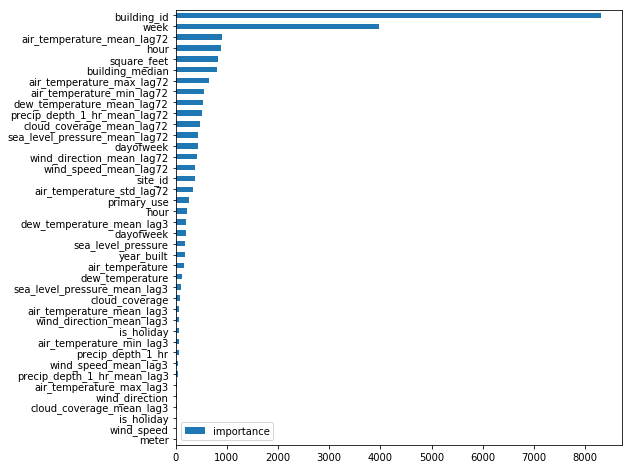

In [67]:
plot_feature_importance(models0[1])

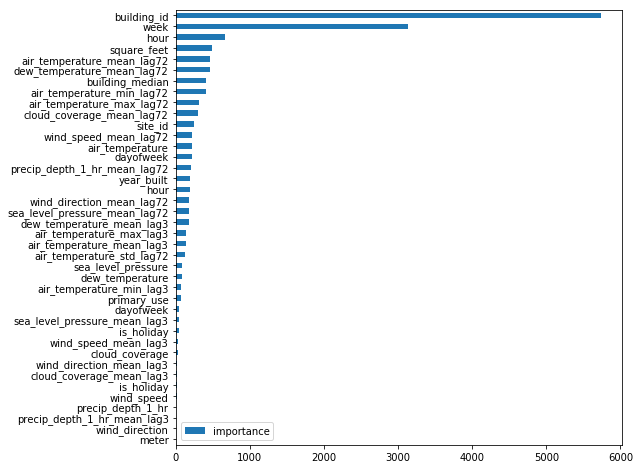

In [68]:
plot_feature_importance(models1[1])

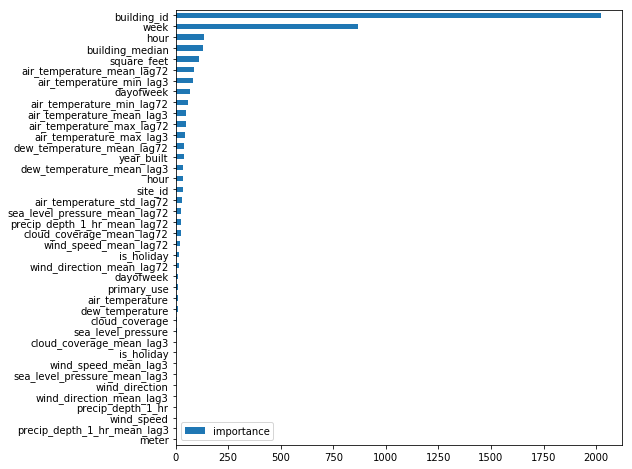

In [69]:
plot_feature_importance(models2[1])

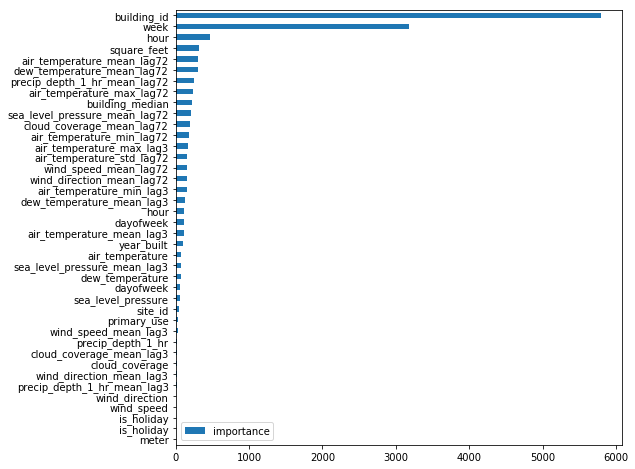

In [70]:
plot_feature_importance(models3[1])

In [71]:
sub = pd.read_csv('submission.csv')
sub

,row_id,meter_reading
0,0,140.6515
1,1,74.6733
2,2,6.1082
3,3,240.8550
4,4,1215.1391
...,...,...
41697595,41697595,6.7666
41697596,41697596,4.6061
41697597,41697597,2.8395
41697598,41697598,178.0529
